In [83]:
import json
from urllib.parse import urlencode
from urllib.request import urlretrieve
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests
from lxml import html

import pickle


In [84]:
def get_nba_data(endpt, params, return_url=False):

    ## endpt: https://github.com/seemethere/nba_py/wiki/stats.nba.com-Endpoint-Documentation
    ## params: dictionary of parameters: i.e., {'LeagueID':'00'}

    useragent = "\"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2) AppleWebKit/601.3.9 (KHTML, like Gecko) Version/9.0.2 Safari/601.3.9\""

    dataurl = "\"" + "http://stats.nba.com/stats/" + endpt + "?" + urlencode(params) + "\""
    
    # for debugging: just return the url
    if return_url:
        return(dataurl)
    
    jsonstr = !wget -q -O - --user-agent={useragent} {dataurl}
    
    data = json.loads(jsonstr[0])
    
    h = data['resultSets'][0]['headers']
    d = data['resultSets'][0]['rowSet']
    
    return(pd.DataFrame(d, columns=h))

Start by exploring combine data

In [85]:
params = {'LeagueID':'00',
          'Season':'2017-18',
          'IsOnlyCurrentSeason':'0'
         }
data = get_nba_data(endpt="commonallplayers",params=params)
data['PLAYER_NAME']=pd.Series(data['DISPLAY_FIRST_LAST'],dtype=str)+"("+pd.Series(data.FROM_YEAR,dtype=str)+")"
data = data.set_index('PLAYER_NAME')
data['PLAYER_ID']=data['PERSON_ID']
Player_ID_Dict = pd.Series(data['PLAYER_ID'],dtype=int)
Player_ID_Dict
Player_ID_Dict = Player_ID_Dict.loc[~Player_ID_Dict.index.duplicated(keep='first')]

pickle.dump(Player_ID_Dict, open('NBAPlayerDict.pkl', 'wb'))

In [4]:
year = "2012-13"
params = {"LeagueID":"00",
          "SeasonYear":year}
endpt = "draftcombinedrillresults"
df1 = get_nba_data(endpt=endpt,params=params)

In [5]:
endpt = "draftcombineplayeranthro"
df2 = get_nba_data(endpt=endpt,params=params)

In [6]:
year = "2013-14"
params = {"LeagueID":"00",
          "SeasonYear":year}
endpt = "draftcombinenonstationaryshooting"
df3 = get_nba_data(endpt=endpt,params=params)

In [7]:
df = pd.merge(df1,df2,on="PLAYER_ID")

Not looking like we'll have the shooting data very constitently. Lets merge two we have consitently and compile it over several years

In [489]:
dfCombineFull = pd.DataFrame(columns=df.columns)
for i in range(10,13):
    year="20"+format(i,'02d')+"-"+format(i+1,'02d')
    params.update({"SeasonYear":year})
    df1 = get_nba_data(endpt="draftcombinedrillresults",params=params)
    df2 = get_nba_data(endpt="draftcombineplayeranthro",params=params)
    dfMerged = pd.merge(df1,df2,on="PLAYER_ID")

    if(i>13):
        dfMerged = pd.merge(df1,df2,on="TEMP_PLAYER_ID")
        dfMerged['PLAYER_NAME'] = dfMerged['PLAYER_NAME_x'] + "(" + year[0:4] + ")"
        dfMerged['PLAYER_ID']=dfMerged['PLAYER_NAME'].map(Player_ID_Dict)
        dfMerged['PLAYER_ID']=pd.Series(dfMerged['PLAYER_ID'],dtype=str).str.split(".").str.get(0)

    dfCombineFull = pd.concat([dfCombineFull,dfMerged])

In [490]:
#dfCombineFull = dfCombineFull.set_index('PLAYER_ID')
dfCombineFull[dfCombineFull.LAST_NAME_x=="Davis"]

,TEMP_PLAYER_ID_x,PLAYER_ID,FIRST_NAME_x,LAST_NAME_x,PLAYER_NAME_x,POSITION_x,STANDING_VERTICAL_LEAP,MAX_VERTICAL_LEAP,LANE_AGILITY_TIME,MODIFIED_LANE_AGILITY_TIME,...,HEIGHT_W_SHOES,HEIGHT_W_SHOES_FT_IN,WEIGHT,WINGSPAN,WINGSPAN_FT_IN,STANDING_REACH,STANDING_REACH_FT_IN,BODY_FAT_PCT,HAND_LENGTH,HAND_WIDTH
13,None,202334,Ed,Davis,Ed Davis,PF,31.0,36.0,11.7,None,...,81.75,6' 9.75'',226.6,84.0,7' 0'',108.0,9' 0'',10.0,9.25,10.0
8,None,203076,Anthony,Davis,Anthony Davis,PF-C,NaN,NaN,NaN,None,...,82.50,6' 10.5'',221.8,89.5,7' 5.5'',108.0,9' 0'',7.9,9.00,8.5


In [10]:
endpt = 'playerdashptshotdefend'
params = {'DateFrom':'','DateTo':'','GameSegment':'',
          'LastNGames':'0','LeagueID':'00','Location':'',
          'Month':'0','OpponentTeamID':'0','Outcome':'',
          'Period':'0','PlayerID':'0','Season':year,
          'SeasonSemgent':'','SeasonType':'Regular Season',
          'TeamID':'0','VsConference':'','VsDivision':'',
          'PerMode':'Totals','SeasonSegment':''
         }
dfDefense = get_nba_data(endpt=endpt,params=params)
dfDefense[dfDefense.DEFENSE_CATEGORY=="Less Than 6 Ft"]


,CLOSE_DEF_PERSON_ID,GP,G,DEFENSE_CATEGORY,FREQ,D_FGM,D_FGA,D_FG_PCT,NORMAL_FG_PCT,PCT_PLUSMINUS
1470,2747,70,58,Less Than 6 Ft,0.203,78.0,112.0,0.696,0.588,0.109
1471,201961,65,44,Less Than 6 Ft,0.162,51.0,80.0,0.638,0.591,0.047
1472,101111,58,45,Less Than 6 Ft,0.409,71.0,114.0,0.623,0.596,0.027
1473,201567,74,74,Less Than 6 Ft,0.408,232.0,414.0,0.560,0.589,-0.028
1474,203475,32,15,Less Than 6 Ft,0.188,16.0,21.0,0.762,0.573,0.189
1475,203897,73,61,Less Than 6 Ft,0.250,98.0,140.0,0.700,0.585,0.115
1476,201583,61,59,Less Than 6 Ft,0.458,170.0,276.0,0.616,0.595,0.021
1477,202388,47,39,Less Than 6 Ft,0.230,53.0,84.0,0.631,0.581,0.050
1478,2738,77,62,Less Than 6 Ft,0.214,86.0,125.0,0.688,0.592,0.096
1479,2590,67,48,Less Than 6 Ft,0.176,83.0,118.0,0.703,0.592,0.112


In [11]:
dfDefense = dfDefense[dfDefense.DEFENSE_CATEGORY=="Less Than 6 Ft"]
dfDefense = dfDefense.set_index("CLOSE_DEF_PERSON_ID")

In [12]:
dfDefense_PCT_Change = pd.DataFrame(dfDefense.PCT_PLUSMINUS)
dfDefense_PCT_Change

,PCT_PLUSMINUS
CLOSE_DEF_PERSON_ID,
2747,0.109
201961,0.047
101111,0.027
201567,-0.028
203475,0.189
203897,0.115
201583,0.021
202388,0.050
2738,0.096


In [13]:
dfCombineFull = pd.merge(dfCombineFull,dfDefense_PCT_Change,left_index=True,right_index=True)

In [14]:
dfCombineFull.groupby('WINGSPAN')['PCT_PLUSMINUS'].mean()

WINGSPAN
70.75    0.131000
72.00    0.273000
72.75    0.139000
73.00    0.065000
73.75    0.060000
74.00    0.077000
74.25    0.158000
74.50    0.045500
74.75    0.030000
75.00    0.079000
75.25    0.098000
75.50    0.055000
75.75    0.038000
76.00   -0.130333
76.25    0.006667
76.50    0.120333
77.00    0.039000
77.50    0.121400
77.75    0.152500
78.00   -0.032600
78.25    0.073000
78.50    0.114000
78.75    0.149000
79.00    0.055333
79.25    0.060875
79.50    0.085000
79.75    0.102000
80.00    0.078250
80.25    0.127000
80.50    0.126000
           ...   
83.50    0.051625
83.75   -0.011000
84.00    0.006000
84.25    0.009000
84.50    0.004250
84.75   -0.028000
85.00    0.034500
85.25   -0.051875
85.50    0.061889
85.75   -0.004000
86.00    0.037000
86.25   -0.015333
86.50    0.002500
86.75   -0.014500
87.00   -0.060143
87.25   -0.065000
87.50   -0.025600
87.75   -0.063500
88.00   -0.082200
88.25    0.001000
88.50   -0.034600
88.75   -0.052500
89.00   -0.051000
89.50   -0.042000
8

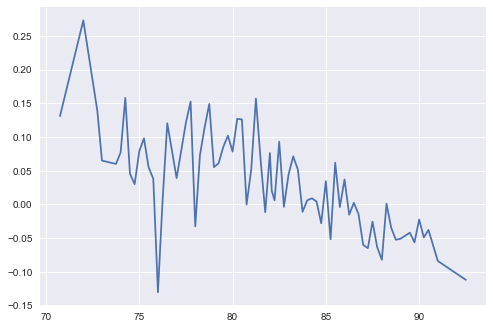

In [15]:
plt.plot(dfCombineFull.groupby('WINGSPAN')['PCT_PLUSMINUS'].mean())

In [16]:
bins = list(range(70,98,2))
dfCombineFull['Wingspan_binned']=pd.cut(dfCombineFull['WINGSPAN'],bins)

In [17]:
dfCombineFull['POSITION_SIMPLE']=np.NaN
dfCombineFull['POSITION_SIMPLE'][dfCombineFull.POSITION_y=="C"]="Big"
dfCombineFull['POSITION_SIMPLE'][dfCombineFull.POSITION_y=="C-PF"]="Big"
dfCombineFull['POSITION_SIMPLE'][dfCombineFull.POSITION_y=="PF-C"]="Big"

dfCombineFull['POSITION_SIMPLE'][dfCombineFull.POSITION_y=="PF"]="Forward"
dfCombineFull['POSITION_SIMPLE'][dfCombineFull.POSITION_y=="SF-PF"]="Forward"
dfCombineFull['POSITION_SIMPLE'][dfCombineFull.POSITION_y=="PF-SF"]="Forward"

dfCombineFull['POSITION_SIMPLE'][dfCombineFull.POSITION_y=="SF"]="Wing"
dfCombineFull['POSITION_SIMPLE'][dfCombineFull.POSITION_y=="SF-SG"]="Wing"
dfCombineFull['POSITION_SIMPLE'][dfCombineFull.POSITION_y=="SG-SF"]="Wing"

dfCombineFull['POSITION_SIMPLE'][dfCombineFull.POSITION_y=="SG"]="Guard"
dfCombineFull['POSITION_SIMPLE'][dfCombineFull.POSITION_y=="PG-SG"]="Guard"
dfCombineFull['POSITION_SIMPLE'][dfCombineFull.POSITION_y=="SG-PG"]="Guard"
dfCombineFull['POSITION_SIMPLE'][dfCombineFull.POSITION_y=="PG"]="Guard"




dfCombineFull.groupby(['POSITION_SIMPLE','Wingspan_binned'])['PCT_PLUSMINUS'].mean()


/Users/davidhoskins/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/davidhoskins/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/davidhoskins/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd fr

POSITION_SIMPLE  Wingspan_binned
Big              (80, 82]          -0.022000
                 (82, 84]          -0.042500
                 (84, 86]          -0.029167
                 (86, 88]          -0.054000
                 (88, 90]          -0.038667
                 (90, 92]          -0.057000
                 (92, 94]          -0.112000
Forward          (80, 82]          -0.009400
                 (82, 84]          -0.007316
                 (84, 86]           0.022520
                 (86, 88]          -0.037476
                 (88, 90]          -0.044500
Guard            (70, 72]           0.202000
                 (72, 74]           0.085250
                 (74, 76]           0.041500
                 (76, 78]           0.061526
                 (78, 80]           0.083839
                 (80, 82]           0.070800
                 (82, 84]           0.104571
Wing             (78, 80]           0.051167
                 (80, 82]           0.086792
                 (82, 

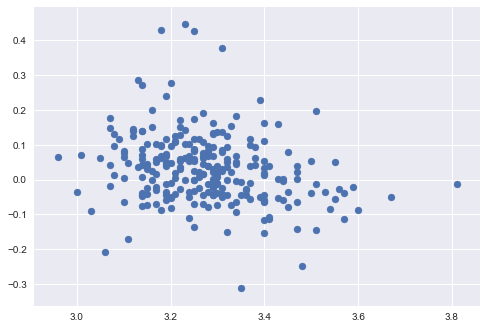

In [18]:
plt.scatter(dfCombineFull['THREE_QUARTER_SPRINT'],dfCombineFull['PCT_PLUSMINUS'])

In [19]:
dfCombineFull.columns

Index(['TEMP_PLAYER_ID_x', 'FIRST_NAME_x', 'LAST_NAME_x', 'PLAYER_NAME_x',
       'POSITION_x', 'STANDING_VERTICAL_LEAP', 'MAX_VERTICAL_LEAP',
       'LANE_AGILITY_TIME', 'MODIFIED_LANE_AGILITY_TIME',
       'THREE_QUARTER_SPRINT', 'BENCH_PRESS', 'TEMP_PLAYER_ID_y',
       'FIRST_NAME_y', 'LAST_NAME_y', 'PLAYER_NAME_y', 'POSITION_y',
       'HEIGHT_WO_SHOES', 'HEIGHT_WO_SHOES_FT_IN', 'HEIGHT_W_SHOES',
       'HEIGHT_W_SHOES_FT_IN', 'WEIGHT', 'WINGSPAN', 'WINGSPAN_FT_IN',
       'STANDING_REACH', 'STANDING_REACH_FT_IN', 'BODY_FAT_PCT', 'HAND_LENGTH',
       'HAND_WIDTH', 'PCT_PLUSMINUS', 'Wingspan_binned', 'POSITION_SIMPLE'],
      dtype='object')

Tomorrow we should work on a simple linear regression from this.
We should also start adding in college status
Need to do data from multiple years/figure out what we want to do regarding that
    averages over full career
    best year
    three years out?
    three year average?

In [20]:
year = 16
year="20"+format(i,'02d')+"-"+format(i+1,'02d')
params.update({"SeasonYear":year})
df1 = get_nba_data(endpt="draftcombinedrillresults",params=params)
df2 = get_nba_data(endpt="draftcombineplayeranthro",params=params)
if(i>13):
    dfMerged = pd.merge(df1,df2,on="TEMP_PLAYER_ID")
    
dfMerged['PLAYER_NAME'] = dfMerged['PLAYER_NAME_x'] + "(" + year[0:4] + ")"
dfMerged['PLAYER_ID']=dfMerged['PLAYER_NAME'].map(Player_ID_Dict)
dfMerged['PLAYER_ID']=pd.Series(dfMerged['PLAYER_ID'],dtype=str).str.split(".").str.get(0)


dfCombineFull = pd.concat([dfCombineFull,dfMerged])
dfMerged

,TEMP_PLAYER_ID,PLAYER_ID_x,FIRST_NAME_x,LAST_NAME_x,PLAYER_NAME_x,POSITION_x,STANDING_VERTICAL_LEAP,MAX_VERTICAL_LEAP,LANE_AGILITY_TIME,MODIFIED_LANE_AGILITY_TIME,...,WEIGHT,WINGSPAN,WINGSPAN_FT_IN,STANDING_REACH,STANDING_REACH_FT_IN,BODY_FAT_PCT,HAND_LENGTH,HAND_WIDTH,PLAYER_NAME,PLAYER_ID
0,14000,None,Jordan,Adams,Jordan Adams,SG,24.5,29.5,12.13,3.05,...,208.8,82.00,6' 10'',102.0,8' 6'',10.80,8.50,7.50,Jordan Adams(2014),203919
1,14001,None,Kyle,Anderson,Kyle Anderson,SF,NaN,NaN,NaN,NaN,...,230.1,86.75,7' 2.75'',107.5,8' 11.5'',13.35,8.25,8.75,Kyle Anderson(2014),203937
2,14002,None,Thanasis,Antetokounmpo,Thanasis Antetokounmpo,SF,31.5,39.5,11.39,3.05,...,205.2,84.00,7' 0'',104.5,8' 8.5'',6.05,9.00,9.75,Thanasis Antetokounmpo(2014),nan
3,14003,None,Isaiah,Austin,Isaiah Austin,PF,26.5,29.5,11.00,3.18,...,219.5,88.50,7' 4.5'',112.5,9' 4.5'',7.50,8.75,8.75,Isaiah Austin(2014),nan
4,14004,None,Jordan,Bachynski,Jordan Bachynski,PF,29.0,33.0,12.15,3.03,...,254.1,88.00,7' 4'',108.5,9' 0.5'',7.45,9.25,10.00,Jordan Bachynski(2014),nan
5,14005,None,Cameron,Bairstow,Cameron Bairstow,PF,31.0,33.5,11.39,3.09,...,252.4,84.75,7' 0.75'',107.0,8' 11'',8.70,8.75,9.00,Cameron Bairstow(2014),203946
6,14006,None,Khem,Birch,Khem Birch,PF,30.5,35.5,11.60,3.24,...,208.8,85.00,7' 1'',107.0,8' 11'',6.00,9.00,8.50,Khem Birch(2014),nan
7,14007,None,Jabari,Brown,Jabari Brown,SG,28.0,32.0,11.60,3.26,...,201.9,80.25,6' 8.25'',100.0,8' 4'',6.05,9.00,9.25,Jabari Brown(2014),203913
8,14008,None,Markel,Brown,Markel Brown,SG,36.5,43.5,12.62,2.90,...,184.4,80.75,6' 8.75'',100.0,8' 4'',4.20,8.25,9.75,Markel Brown(2014),203900
9,14062,None,Alec,Brown,Alec Brown,PF,27.0,30.0,12.05,2.91,...,231.2,85.50,7' 1.5'',109.0,9' 1'',7.70,9.25,8.75,Alec Brown(2014),nan


In [21]:
Player_ID_Dict = Player_ID_Dict.loc[~Player_ID_Dict.index.duplicated(keep='first')]

In [479]:
Player_ID_Dict['Anthony Davis(20)']

PLAYER_NAME
Alaa Abdelnaby(1990)           76001
Zaid Abdul-Aziz(1968)          76002
Kareem Abdul-Jabbar(1969)      76003
Mahmoud Abdul-Rauf(1990)          51
Tariq Abdul-Wahad(1997)         1505
Shareef Abdur-Rahim(1996)        949
Tom Abernethy(1976)            76005
Forest Able(1956)              76006
John Abramovic(1946)           76007
Alex Abrines(2016)            203518
Alex Acker(2005)              101165
Donald Ackerman(1953)          76008
Mark Acres(1987)               76009
Charles Acton(1967)            76010
Quincy Acy(2012)              203112
Alvan Adams(1975)              76011
Don Adams(1970)                76012
Hassan Adams(2006)            200801
Jordan Adams(2014)            203919
Michael Adams(1985)              149
Steven Adams(2013)            203500
Rafael Addison(1986)             912
Bam Adebayo(2017)            1628389
Rick Adelman(1968)             76015
Jeff Adrien(2010)             202399
Arron Afflalo(2007)           201167
Maurice Ager(2006)        

Going to start pulling college stats from bball ref but might get my IP banned which is less than ideal.

In [23]:
nameList = []
for player in dfCombineFull.index:
    nameStr = 'https://www.sports-reference.com/cbb/players/'
    
    nameStr += str(dfCombineFull.FIRST_NAME_x[player]).lower() +"-" + \
                str(dfCombineFull.LAST_NAME_x[player]).lower() + "-1.html"
    
    nameList.append(nameStr)

In [24]:
testCase = 'https://www.sports-reference.com/cbb/players/deandre-ayton-1.html'

In [25]:
data_url = 'https://www.sports-reference.com/cbb/players/malcolm-brogdon-1.html'
user_agent = "\"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2) AppleWebKit/601.3.9 (KHTML, like Gecko) Version/9.0.2 Safari/601.3.9\""

headers = {'User-Agent':user_agent}
page = requests.get(data_url,headers=headers)
tree = html.fromstring(page.content)

In [66]:

x = tree.xpath('//div[@id="all_players_per_poss"]')
n = len(str(x[0].getchildren()[-1]))

tree2 = html.fromstring(str(x[0].getchildren()[-1])[6:(n-3)])
tree2.xpath('//table/tfoot/tr/td/text()')

['Virginia',
 '136',
 '109',
 '4157',
 '9.6',
 '22.3',
 '.430',
 '6.6',
 '14.2',
 '.466',
 '2.9',
 '8.1',
 '.365',
 '6.7',
 '7.7',
 '.876',
 '9.0',
 '5.3',
 '1.9',
 '0.5',
 '3.3',
 '4.0',
 '28.8',
 '114.9',
 '94.0']

In [45]:
x = tree.xpath('//div[@id="all_leaderboard"]')
n = len(str(x[0].getchildren()[-1]))

tree2 = html.fromstring(str(x[0].getchildren()[-1])[6:(n-3)])
tree2.xpath('//table/tr/td/a/text')

[<!-- 	<div class="data_grid" id="div_leaderboard" data-entry-type="Leaderboards">
 <div id="leaderboard_awards" class="data_grid_box">
 	<table class="no_columns">
 		<caption>Awards</caption>		<tr class="">			<td class="single"><a href="/cbb/seasons/2015.html">2014-15</a> <a href="/cbb/awards/all-america-2010-2019.html">Consensus All-America</a>&nbsp;(2nd Tm)<br>
 </td>
 		</tr>
 				<tr class="">			<td class="single"><a href="/cbb/seasons/2015.html">2014-15</a> <a href="/cbb/awards/usbwa-final.html">USBWA Player of the Year Finalists</a><br>
 </td>
 		</tr>
 				<tr class="">			<td class="single"><a href="/cbb/seasons/2015.html">2014-15</a> <a href="/cbb/awards/wooden-final.html">Wooden Award - Finalists</a><br>
 </td>
 		</tr>
 				<tr class="">			<td class="single"><a href="/cbb/seasons/2015.html">2014-15</a> <a href="/cbb/awards/wooden-pre.html">Wooden Award - Preseason</a><br>
 </td>
 		</tr>
 				<tr class="">			<td class="single"><a href="/cbb/seasons/2016.html">2015-16</a> <a

In [27]:
x = soup.find_all('td')

NameError: name 'soup' is not defined

In [28]:
//*[@id="all_leaderboard"]

SyntaxError: invalid syntax (<ipython-input-28-969b49f4123e>, line 1)

In [29]:
nameList

['https://www.sports-reference.com/cbb/players/jamal-crawford-1.html',
 'https://www.sports-reference.com/cbb/players/tyson-chandler-1.html',
 'https://www.sports-reference.com/cbb/players/jason-richardson-1.html',
 'https://www.sports-reference.com/cbb/players/joe-johnson-1.html',
 'https://www.sports-reference.com/cbb/players/richard-jefferson-1.html',
 'https://www.sports-reference.com/cbb/players/brendan-haywood-1.html',
 'https://www.sports-reference.com/cbb/players/mike-dunleavy-1.html',
 'https://www.sports-reference.com/cbb/players/drew-gooden-1.html',
 'https://www.sports-reference.com/cbb/players/nene--1.html',
 "https://www.sports-reference.com/cbb/players/amar'e-stoudemire-1.html",
 'https://www.sports-reference.com/cbb/players/caron-butler-1.html',
 'https://www.sports-reference.com/cbb/players/john-salmons-1.html',
 'https://www.sports-reference.com/cbb/players/carlos-boozer-1.html',
 'https://www.sports-reference.com/cbb/players/matt-barnes-1.html',
 'https://www.sports-

In [523]:
#dfCombineFull = pd.DataFrame(columns=df.columns)
i = 17
year="20"+format(i,'02d')+"-"+format(i+1,'02d')
params.update({"SeasonYear":year})
df1 = get_nba_data(endpt="draftcombinedrillresults",params=params)
df2 = get_nba_data(endpt="draftcombineplayeranthro",params=params)


dfMerged = pd.merge(df1,df2)

if(i>13):
    dfMerged['PLAYER_NAME'] = dfMerged['PLAYER_NAME'] + "(" + year[0:4] + ")"
    dfMerged['PLAYER_ID']=dfMerged['PLAYER_NAME'].map(Player_ID_Dict)
    dfMerged['PLAYER_ID']=pd.Series(dfMerged['PLAYER_ID'],dtype=str).str.split(".").str.get(0)

    
dfMerged = dfMerged[dfMerged['PLAYER_ID']!='nan']

dfMerged = dfMerged[dfMerged['MAX_VERTICAL_LEAP']!=np.nan]\
                    .set_index('PLAYER_ID')\
                    .drop(['FIRST_NAME','LAST_NAME'],axis=1)
#.set_index('PLAYER_ID')
#dfCombineFull = pd.concat([dfCombineFull,dfMerged])
dfMerged

,TEMP_PLAYER_ID,PLAYER_NAME,POSITION,STANDING_VERTICAL_LEAP,MAX_VERTICAL_LEAP,LANE_AGILITY_TIME,MODIFIED_LANE_AGILITY_TIME,THREE_QUARTER_SPRINT,BENCH_PRESS,HEIGHT_WO_SHOES,...,HEIGHT_W_SHOES,HEIGHT_W_SHOES_FT_IN,WEIGHT,WINGSPAN,WINGSPAN_FT_IN,STANDING_REACH,STANDING_REACH_FT_IN,BODY_FAT_PCT,HAND_LENGTH,HAND_WIDTH
PLAYER_ID,,,,,,,,,,,,,,,,,,,,,
1628386,17002,Jarrett Allen(2017),C,31.5,35.5,11.82,3.00,3.21,None,81.00,...,82.25,6' 10.25'',233.6,89.25,7' 5.25'',109.5,9' 1.5'',7.4,9.50,10.50
1628443,17003,Kadeem Allen(2017),PG,33.0,35.5,11.24,2.98,3.15,None,73.00,...,74.25,6' 2.25'',192.4,81.25,6' 9.25'',99.5,8' 3.5'',6.4,8.50,8.75
1628387,17004,Ike Anigbogu(2017),C,29.5,32.5,12.52,3.48,3.44,None,80.50,...,81.75,6' 9.75'',252.2,90.25,7' 6.25'',110.5,9' 2.5'',5.4,9.50,10.00
1628384,17005,OG Anunoby(2017),SF,NaN,NaN,NaN,NaN,NaN,None,78.25,...,79.75,6' 7.75'',232.4,86.25,7' 2.25'',107.5,8' 11.5'',6.8,9.25,9.50
1628503,17006,Jamel Artis(2017),SG-SF,23.5,31.0,11.62,3.08,3.44,None,77.50,...,78.75,6' 6.75'',213.2,82.00,6' 10'',105.0,8' 9'',11.9,9.25,9.75
1628407,17007,Dwayne Bacon(2017),SG-SF,30.0,36.5,11.70,3.22,3.22,None,76.75,...,78.25,6' 6.25'',221.6,82.00,6' 10'',103.5,8' 7.5'',7.9,8.75,10.00
1628395,17009,Jordan Bell(2017),PF,31.5,38.0,10.63,2.83,3.21,None,79.00,...,80.50,6' 8.5'',223.6,83.75,6' 11.75'',104.5,8' 8.5'',5.4,9.25,9.50
1628449,17011,Chris Boucher(2017),PF,NaN,NaN,NaN,NaN,NaN,None,80.00,...,81.50,6' 9.5'',182.2,88.00,7' 4'',110.5,9' 2.5'',5.4,9.25,10.50
1628396,17012,Tony Bradley(2017),C,24.5,27.5,11.79,2.99,3.44,None,81.25,...,82.75,6' 10.75'',248.8,89.00,7' 5'',112.5,9' 4.5'',12.0,9.50,9.50


In [475]:
nameList = []
yearList = []
for name in dfMerged.PLAYER_NAME:
    nameStr = 'https://www.sports-reference.com/cbb/players/'
    first = re.sub('[^a-zA-Z]+', '',name.split()[0].lower())
    last = "".join(name.split()[1:])[0:-6].lower().strip(".")
    year = name.split()[1][-5:-1]
    yearList.append(year)
    nameStr += first + "-" + last + "-"
    nameList.append(nameStr)
    


In [474]:
nameList

['https://www.sports-reference.com/cbb/players/jarrett-allen-',
 'https://www.sports-reference.com/cbb/players/kadeem-allen-',
 'https://www.sports-reference.com/cbb/players/ike-anigbogu-',
 'https://www.sports-reference.com/cbb/players/og-anunoby-',
 'https://www.sports-reference.com/cbb/players/jamel-artis-',
 'https://www.sports-reference.com/cbb/players/dwayne-bacon-',
 'https://www.sports-reference.com/cbb/players/jordan-bell-',
 'https://www.sports-reference.com/cbb/players/chris-boucher-',
 'https://www.sports-reference.com/cbb/players/tony-bradley-',
 'https://www.sports-reference.com/cbb/players/dillon-brooks-',
 'https://www.sports-reference.com/cbb/players/thomas-bryant-',
 'https://www.sports-reference.com/cbb/players/zach-collins-',
 'https://www.sports-reference.com/cbb/players/john-collins-',
 'https://www.sports-reference.com/cbb/players/tyler-dorsey-',
 'https://www.sports-reference.com/cbb/players/damyean-dotson-',
 'https://www.sports-reference.com/cbb/players/pj-doz

In [456]:
rowDf = pd.DataFrame(columns=row.columns)
for indx,name in enumerate(nameList):
    stopCondition = False
    year = yearList[indx]
    i = 1

    while not stopCondition:
        data_url = name + str(i) + ".html"
        print(data_url)
        player_id = dfMerged.index[indx]
        player_name = dfMerged.PLAYER_NAME[indx]
        user_agent = "\"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2) AppleWebKit/601.3.9 (KHTML, like Gecko) Version/9.0.2 Safari/601.3.9\""

        headers = {'User-Agent':user_agent}
        page = requests.get(data_url,headers=headers)
        tree = html.fromstring(page.content)

        if '404' not in tree.xpath('//title')[0].text:
            finalYear = tree.xpath('//table/tbody/tr')[-1].items()[0][-1][-4:]

            if (finalYear != year):
                i+=1
                continue
            else:
                stopCondition = True

            treeStr = str(tree.xpath('//div[@id="all_players_per_poss"]')[0]\
                            .getchildren()[-1])[8:-4]

            tree2 = html.fromstring(treeStr)
            valuesHTML = tree2.xpath('//table/tfoot/tr')[-1].getchildren()[1:]
            conf = tree2.xpath('//table/tbody/tr/td')[1].getchildren()[0].text
            colNamesHTML = tree2.xpath('//table/thead/tr/th')
            colNames = ["PLAYER_ID","PLAYER_NAME"]+["CONF"] + [col.text for col in colNamesHTML][1:]
            values = [player_id,player_name] + [conf] + [val.text for val in valuesHTML]

            row = pd.DataFrame(pd.Series(values,index=colNames)\
                    .dropna()).transpose().set_index("PLAYER_ID")

        else:
            stopCondition=True
            row = None
    rowDf = pd.concat([rowDf,row])
    print(indx)
    
#Fixing juniors is going to require a functional approach to this. 

https://www.sports-reference.com/cbb/players/jarrett-allen-1.html
0
https://www.sports-reference.com/cbb/players/kadeem-allen-1.html
1
https://www.sports-reference.com/cbb/players/ike-anigbogu-1.html
2
https://www.sports-reference.com/cbb/players/og-anunoby-1.html
3
https://www.sports-reference.com/cbb/players/jamel-artis-1.html
4
https://www.sports-reference.com/cbb/players/dwayne-bacon-1.html
5
https://www.sports-reference.com/cbb/players/jordan-bell-1.html
6
https://www.sports-reference.com/cbb/players/chris-boucher-1.html
7
https://www.sports-reference.com/cbb/players/tony-bradley-1.html
8
https://www.sports-reference.com/cbb/players/dillon-brooks-1.html
9
https://www.sports-reference.com/cbb/players/thomas-bryant-1.html
10
https://www.sports-reference.com/cbb/players/zach-collins-1.html
11
https://www.sports-reference.com/cbb/players/john-collins-1.html
12
https://www.sports-reference.com/cbb/players/tyler-dorsey-1.html
13
https://www.sports-reference.com/cbb/players/damyean-dotso

In [478]:
len(dfMerged)

43

Need to make that into a function soon. Fuck it why not now.

In [555]:
def SportsRefCBBRowMaker(player_url,table_name,player_name,correct_year):
    player_id = Player_ID_Dict[player_name]
    
    page = requests.get(player_url,headers=headers)
    tree = html.fromstring(page.content)
    
    if '404' in tree.xpath('//title')[0].text:
        return('404')
    
    else:
        year = tree.xpath('//table/tbody/tr')[-1].items()[0][-1][-4:]
        if(year!=correct_year):
            return(year)
        path = '//div[@id="'+table_name+'"]'
        treeStr = str(tree.xpath(path)[0].getchildren()[-1])[8:-4]
        #This is tricky and comments might be nice here. 

        tree2 = html.fromstring(treeStr)
        
        valuesHTML = tree2.xpath('//table/tfoot/tr')[-1].getchildren()[1:]
        ## This gives career in particular 
        conf = tree2.xpath('//table/tbody/tr/td')[1].getchildren()[0].text
        colNamesHTML = tree2.xpath('//table/thead/tr/th')
        colNames = ["PLAYER_ID","PLAYER_NAME"]+["CONF"] + [col.text for col in colNamesHTML][1:]
        values = [player_id,player_name] + [conf] + [val.text for val in valuesHTML]

        row = pd.DataFrame(pd.Series(values,index=colNames)\
                .dropna()).transpose().set_index("PLAYER_ID")
 #       print(player_url)
        return(row)
    

In [559]:
def sportsRefCBBTableMaker(player_df, table_name):
    base_url = 'https://www.sports-reference.com/cbb/players/'
    columns_df_url = "https://www.sports-reference.com/cbb/players/malcolm-brogdon-1.html"
    columns_df = SportsRefCBBRowMaker(columns_df_url,table_name
                                      ,"Malcolm Brogdon(2016)",'2016')
    CBB_df = pd.DataFrame(columns=columns_df.columns)
    for index,row in dfMerged.iterrows():
        player_name = row['PLAYER_NAME']
        first = re.sub('[^a-zA-Z]+', '',player_name.split()[0].lower())
        last = "".join(player_name.split()[1:])[0:-6].lower().strip(".")
        year = player_name.split()[1][-5:-1]
        name_url = base_url + first + "-" + last + "-"

        i = 1
        stopping_condition=False
        while(stopping_condition==False):
            data_url = name_url + str(i) + ".html"
#            print(data_url)
            row = SportsRefCBBRowMaker(data_url,table_name,player_name,year)
            if isinstance(row, pd.DataFrame):
                stopping_condition=True
                continue
            if(row=='404'):
                stopping_condition=True
                row = None
                if(last[-2:]=="jr"):
                    last = last[:-2]
                    name_url = base_url + first + "-" + last + "-"
                    i=1
                    stopping_condition = False 
            i+=1
        CBB_df = pd.concat([CBB_df,row])
    return(CBB_df)

In [560]:
sportsRefCBBTableMaker(dfMerged, "all_players_per_poss")

,2P,2P%,2PA,3P,3P%,3PA,AST,BLK,CONF,DRtg,...,GS,MP,ORtg,PF,PLAYER_NAME,PTS,STL,School,TOV,TRB
1628386,9.8,.579,17.0,0.0,.000,0.4,1.5,2.8,Big 12,99.9,...,33,1061,104.8,3.7,Jarrett Allen(2017),24.3,1.0,Texas,4.6,15.3
1628443,4.9,.482,10.2,1.6,.400,3.9,6.9,1.5,Pac-12,96.3,...,61,1868,109.5,5.2,Kadeem Allen(2017),19.3,2.8,Arizona,4.2,7.6
1628387,8.1,.564,14.4,0.0,NaN,0.0,0.9,5.0,Pac-12,98.4,...,0,377,109.0,10.3,Ike Anigbogu(2017),19.6,0.7,UCLA,3.4,16.7
1628384,7.1,.652,10.9,1.8,.365,4.9,2.7,3.1,Big Ten,98.4,...,10,868,117.7,5.7,OG Anunoby(2017),22.8,3.2,Indiana,3.6,11.8
1628503,6.8,.524,13.0,2.8,.378,7.5,5.1,0.7,ACC,107.2,...,98,3726,114.3,3.9,Jamel Artis(2017),28.2,1.0,Pitt,4.2,10.4
1628407,9.2,.510,18.0,2.5,.312,7.9,3.1,0.1,ACC,104.0,...,67,1987,107.8,3.6,Dwayne Bacon(2017),31.8,1.9,Florida State,4.0,9.6
1628395,7.7,.622,12.3,0.1,.188,0.4,3.5,5.3,Pac-12,91.9,...,62,2591,116.7,5.4,Jordan Bell(2017),18.3,2.5,Oregon,3.6,16.1
1628449,7.6,.650,11.7,2.5,.344,7.3,0.9,6.4,Pac-12,92.7,...,47,1712,123.8,6.2,Chris Boucher(2017),27.8,1.4,Oregon,2.5,15.8
1628396,10.1,.573,17.7,0.0,NaN,0.0,2.3,2.2,ACC,97.6,...,0,553,129.1,6.9,Tony Bradley(2017),26.8,1.0,UNC,2.5,19.4
1628415,8.4,.518,16.1,2.4,.362,6.8,5.1,0.9,Pac-12,102.5,...,98,3153,113.8,5.9,Dillon Brooks(2017),29.7,1.8,Oregon,4.3,9.1


,TEMP_PLAYER_ID_x,PLAYER_ID,FIRST_NAME_x,LAST_NAME_x,PLAYER_NAME_x,POSITION_x,STANDING_VERTICAL_LEAP,MAX_VERTICAL_LEAP,LANE_AGILITY_TIME,MODIFIED_LANE_AGILITY_TIME,...,HEIGHT_W_SHOES,HEIGHT_W_SHOES_FT_IN,WEIGHT,WINGSPAN,WINGSPAN_FT_IN,STANDING_REACH,STANDING_REACH_FT_IN,BODY_FAT_PCT,HAND_LENGTH,HAND_WIDTH
0,None,202374,Solomon,Alabi,Solomon Alabi,C,22.5,26.0,13.20,None,...,84.75,7' 0.75'',237.4,89.00,7' 5'',113.0,9' 5'',5.0,9.25,9.25
1,None,202332,Cole,Aldrich,Cole Aldrich,C,23.0,28.0,11.48,None,...,83.25,6' 11.25'',236,88.75,7' 4.75'',111.5,9' 3.5'',8.5,9.00,9.25
2,None,202329,Al-Farouq,Aminu,Al-Farouq Aminu,SF,27.0,33.5,11.29,None,...,80.50,6' 8.5'',216,87.25,7' 3.25'',108.5,9' 0.5'',8.2,9.50,9.50
3,None,202341,James,Anderson,James Anderson,SF,30.0,35.5,11.86,None,...,77.75,6' 5.75'',207.6,80.50,6' 8.5'',104.0,8' 8'',7.9,8.50,7.25
4,None,202337,Luke,Babbitt,Luke Babbitt,SF-PF,29.5,37.5,10.98,None,...,80.75,6' 8.75'',217.8,83.25,6' 11.25'',104.5,8' 8.5'',5.6,8.50,10.00
5,None,202339,Eric,Bledsoe,Eric Bledsoe,PG,NaN,NaN,NaN,None,...,73.50,6' 1.5'',191.6,79.50,6' 7.5'',98.0,8' 2'',5.6,8.50,9.75
6,None,202344,Trevor,Booker,Trevor Booker,PF,31.0,36.0,11.15,None,...,79.50,6' 7.5'',235.8,81.75,6' 9.75'',106.0,8' 10'',7.3,9.00,9.50
7,None,202342,Craig,Brackins,Craig Brackins,PF-SF,26.0,35.0,11.65,None,...,81.75,6' 9.75'',229,84.00,7' 0'',109.0,9' 1'',7.9,9.50,11.25
8,None,202340,Avery,Bradley,Avery Bradley,SG-PG,31.5,37.5,11.47,None,...,75.25,6' 3.25'',180.4,79.25,6' 7.25'',98.5,8' 2.5'',4.0,8.25,9.50
9,None,202382,Derrick,Caracter,Derrick Caracter,PF,25.0,30.5,12.78,None,...,81.50,6' 9.5'',280,84.25,7' 0.25'',107.5,8' 11.5'',12.8,9.00,10.25


In [ ]:
dfCombineFull = pd.DataFrame(columns=df.columns)
for i in range(10,13):
    year="20"+format(i,'02d')+"-"+format(i+1,'02d')
    params.update({"SeasonYear":year})
    df1 = get_nba_data(endpt="draftcombinedrillresults",params=params)
    df2 = get_nba_data(endpt="draftcombineplayeranthro",params=params)
    dfMerged = pd.merge(df1,df2,on="PLAYER_ID")

    if(i>13):
        dfMerged = pd.merge(df1,df2,on="TEMP_PLAYER_ID")
        dfMerged['PLAYER_NAME'] = dfMerged['PLAYER_NAME_x'] + "(" + year[0:4] + ")"
        dfMerged['PLAYER_ID']=dfMerged['PLAYER_NAME'].map(Player_ID_Dict)
        dfMerged['PLAYER_ID']=pd.Series(dfMerged['PLAYER_ID'],dtype=str).str.split(".").str.get(0)

    dfCombineFull = pd.concat([dfCombineFull,dfMerged])

In [632]:
full_combine_df = pd.DataFrame(columns = combine_columns)
combine_columns = ['PLAYER_NAME','DRAFT_YEAR','POSITION','STANDING_VERTICAL_LEAP',
                   'MAX_VERTICAL_LEAP','LANE_AGILITY_TIME',
                   'MODIFIED_LANE_AGILITY_TIME','THREE_QUARTER_SPRINT',
                   'BENCH_PRESS','HEIGHT_WO_SHOES','WEIGHT','WINGSPAN',
                   'STANDING_REACH','BODY_FAT_PCT','HAND_LENGTH','HAND_WIDTH'                  
                  ]
for i in range(0,19):
    year="20"+format(i,'02d')+"-"+format(i+1,'02d')
    params.update({"SeasonYear":year})
    df1 = get_nba_data(endpt="draftcombinedrillresults",params=params)
    df2 = get_nba_data(endpt="draftcombineplayeranthro",params=params)
    dfMerged = pd.merge(df1,df2)
    dfMerged['PLAYER_ID']=pd.Series(dfMerged.PLAYER_ID,dtype=str)
    if(i>13):
        dfMerged['PLAYER_NAME'] = dfMerged['PLAYER_NAME']
        dfMerged['PLAYER_ID']=(dfMerged['PLAYER_NAME']+"("+year[0:4]+")").map(Player_ID_Dict)
        dfMerged['PLAYER_ID']=pd.Series(dfMerged['PLAYER_ID'],dtype=str).str.split(".").str.get(0)

    dfMerged['DRAFT_YEAR'] = int(year[0:4])    
    dfMerged = dfMerged[dfMerged['PLAYER_ID']!='nan']

    dfMerged = dfMerged[dfMerged['MAX_VERTICAL_LEAP']!=np.nan]\
                        .set_index('PLAYER_ID')[combine_columns]
        
    full_combine_df = pd.concat([full_combine_df,dfMerged])
full_combine_df.fillna(value=np.nan, inplace=True)
full_combine_df

,PLAYER_NAME,DRAFT_YEAR,POSITION,STANDING_VERTICAL_LEAP,MAX_VERTICAL_LEAP,LANE_AGILITY_TIME,MODIFIED_LANE_AGILITY_TIME,THREE_QUARTER_SPRINT,BENCH_PRESS,HEIGHT_WO_SHOES,WEIGHT,WINGSPAN,STANDING_REACH,BODY_FAT_PCT,HAND_LENGTH,HAND_WIDTH
2124,Malik Allen,2000,PF-C,25.5,29.0,11.83,NaN,3.38,13.0,80.25,271,86.50,109.0,NaN,NaN,NaN
12019,Harold Arceneaux,2000,SG-SF,NaN,29.0,13.80,NaN,NaN,0.0,76.50,219,80.50,103.0,NaN,NaN,NaN
12020,Lamont Barnes,2000,PF-C,28.0,29.5,12.30,NaN,3.40,10.0,80.50,235.5,87.50,108.0,NaN,NaN,NaN
12131,Mario Bland,2000,PF,27.0,31.0,13.04,NaN,3.47,15.0,77.50,287,84.00,103.0,NaN,NaN,NaN
2056,Primoz Brezec,2000,C,26.0,29.5,11.53,NaN,3.55,NaN,84.75,243,86.00,110.0,NaN,NaN,NaN
2081,Ernest Brown,2000,C,NaN,NaN,NaN,NaN,NaN,2.0,82.00,222.5,85.25,109.5,NaN,NaN,NaN
2049,Speedy Claxton,2000,PG,36.0,42.5,10.48,NaN,3.06,6.0,70.50,166,72.00,94.5,NaN,NaN,NaN
12132,Eric Coley,2000,SG-SF,35.0,38.0,11.40,NaN,3.15,10.0,76.00,205,83.00,102.0,NaN,NaN,NaN
12133,Ed Cota,2000,PG,26.5,33.5,10.98,NaN,3.24,1.0,72.25,189,76.00,96.5,NaN,NaN,NaN
12134,Schea Cotton,2000,SF,34.0,38.0,11.55,NaN,3.00,19.0,76.25,219.5,79.00,100.0,NaN,NaN,NaN


In [633]:
full_combine_df.groupby('DRAFT_YEAR').count()

,PLAYER_NAME,POSITION,STANDING_VERTICAL_LEAP,MAX_VERTICAL_LEAP,LANE_AGILITY_TIME,MODIFIED_LANE_AGILITY_TIME,THREE_QUARTER_SPRINT,BENCH_PRESS,HEIGHT_WO_SHOES,WEIGHT,WINGSPAN,STANDING_REACH,BODY_FAT_PCT,HAND_LENGTH,HAND_WIDTH
DRAFT_YEAR,,,,,,,,,,,,,,,
2000,65,65,59,60,61,0,58,62,65,65,65,65,0,0,0
2001,78,78,77,77,76,0,77,77,78,78,78,78,76,0,0
2002,82,82,73,73,73,0,72,77,82,82,82,82,0,0,0
2003,78,78,72,71,70,0,71,75,78,78,78,78,77,0,0
2004,81,81,71,71,71,0,71,69,79,79,79,79,80,0,0
2005,81,81,72,72,71,0,72,75,80,80,80,80,0,0,0
2006,76,76,76,76,76,0,76,73,76,76,76,76,76,0,0
2007,77,77,75,75,75,0,74,75,76,76,76,76,76,0,0
2008,76,76,69,68,68,0,68,74,76,76,76,75,76,0,0


In [635]:
full_combine_df

,PLAYER_NAME,DRAFT_YEAR,POSITION,STANDING_VERTICAL_LEAP,MAX_VERTICAL_LEAP,LANE_AGILITY_TIME,MODIFIED_LANE_AGILITY_TIME,THREE_QUARTER_SPRINT,BENCH_PRESS,HEIGHT_WO_SHOES,WEIGHT,WINGSPAN,STANDING_REACH,BODY_FAT_PCT,HAND_LENGTH,HAND_WIDTH
2124,Malik Allen,2000,PF-C,25.5,29.0,11.83,NaN,3.38,13.0,80.25,271,86.50,109.0,NaN,NaN,NaN
12019,Harold Arceneaux,2000,SG-SF,NaN,29.0,13.80,NaN,NaN,0.0,76.50,219,80.50,103.0,NaN,NaN,NaN
12020,Lamont Barnes,2000,PF-C,28.0,29.5,12.30,NaN,3.40,10.0,80.50,235.5,87.50,108.0,NaN,NaN,NaN
12131,Mario Bland,2000,PF,27.0,31.0,13.04,NaN,3.47,15.0,77.50,287,84.00,103.0,NaN,NaN,NaN
2056,Primoz Brezec,2000,C,26.0,29.5,11.53,NaN,3.55,NaN,84.75,243,86.00,110.0,NaN,NaN,NaN
2081,Ernest Brown,2000,C,NaN,NaN,NaN,NaN,NaN,2.0,82.00,222.5,85.25,109.5,NaN,NaN,NaN
2049,Speedy Claxton,2000,PG,36.0,42.5,10.48,NaN,3.06,6.0,70.50,166,72.00,94.5,NaN,NaN,NaN
12132,Eric Coley,2000,SG-SF,35.0,38.0,11.40,NaN,3.15,10.0,76.00,205,83.00,102.0,NaN,NaN,NaN
12133,Ed Cota,2000,PG,26.5,33.5,10.98,NaN,3.24,1.0,72.25,189,76.00,96.5,NaN,NaN,NaN
12134,Schea Cotton,2000,SF,34.0,38.0,11.55,NaN,3.00,19.0,76.25,219.5,79.00,100.0,NaN,NaN,NaN


Lets simply build a full NBA Season database over last however many years.
Probably indexed on player ID, season, with years experience in here somewhere. 



In [644]:
x = get_nba_data(endpt="drafthistory",params={'LeagueID':'00'})
x[x.SEASON=='2016'].head()

,PERSON_ID,PLAYER_NAME,SEASON,ROUND_NUMBER,ROUND_PICK,OVERALL_PICK,TEAM_ID,TEAM_CITY,TEAM_NAME,TEAM_ABBREVIATION,ORGANIZATION,ORGANIZATION_TYPE
60,1627732,Ben Simmons,2016,1,1,1,1610612755,Philadelphia,76ers,PHI,Louisiana State,College/University
61,1627742,Brandon Ingram,2016,1,2,2,1610612747,Los Angeles,Lakers,LAL,Duke,College/University
62,1627759,Jaylen Brown,2016,1,3,3,1610612738,Boston,Celtics,BOS,California,College/University
63,1627733,Dragan Bender,2016,1,4,4,1610612756,Phoenix,Suns,PHX,Maccabi Tel Aviv B.C. (Israel),Other Team/Club
64,1627739,Kris Dunn,2016,1,5,5,1610612750,Minnesota,Timberwolves,MIN,Providence,College/University


Using schools and draft data can save a lot of requests perhaps. 

In [648]:
x = get_nba_data(endpt="leaguedashlineups",params={'LeagueID':'00'},
                return_url=True)
x

'"http://stats.nba.com/stats/leaguedashlineups?LeagueID=00"'

First approach to a comprehensive nba database will follow stats used in the clustering analysis I am to follow.

We're going to follow of this medium post which was referenced on HW3.
https://fastbreakdata.com/classifying-the-modern-nba-player-with-machine-learning-539da03bb824

My man used selium to scrape from bbal reference which is probably smarter than what I did. I turn to stats.nba as the API is pretty usable.

He uses per 100 possesion, advanced and shooting data. I shall use the same but add in some defensive matchup data. 

He used career which I am going to not do. I'll use last 3 years or something. Perhaps limited by the player tracking. I also will add in some team data as what kind of offense you run and things likely has a big impact on what position you'll be playing? Maybe I shouldn't do this actually. Will consider.

Lets start building our giant beautiful database and then define a bunch of variables that can be used to selectively choose columns.

We'll use regular seson data but a playoff data analysis might be more fun later on for somehing else idk.


Since we're going to be doing a somewhat decent amount of figuring out parameters through looking at what exists on the nba site I'm going to define a little function here.

In [793]:
url = 'http://stats.nba.com/stats/leaguedashplayerstats?College=&Conference=&Country=&DateFrom=&DateTo=&Division=&DraftPick=&DraftYear=&GameScope=&GameSegment=&Height=&LastNGames=0&LeagueID=00&Location=&MeasureType=Advanced&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerExperience=&PlayerPosition=&PlusMinus=N&Rank=N&Season=2017-18&SeasonSegment=&SeasonType=Regular+Season&ShotClockRange=&StarterBench=&TeamID=0&VsConference=&VsDivision=&Weight='
    
def get_params(url):
    endpt = url.split('stats/')[1].split('?')[0]
    params = {}
    paramstring = url.split('stats/')[1].split('?')[1]

    for substring in paramstring.split("&"):
        variable = substring.split('=')[0]
        value = substring.split('=')[1]
        params.update({variable:value})
    return([endpt,params])
endpt,params = get_params(url)
params.update({'SeasonType':'Regular Season'})
print(params)
advanced_2017_18 = get_nba_data(endpt=endpt,params=params)

{'College': '', 'Conference': '', 'Country': '', 'DateFrom': '', 'DateTo': '', 'Division': '', 'DraftPick': '', 'DraftYear': '', 'GameScope': '', 'GameSegment': '', 'Height': '', 'LastNGames': '0', 'LeagueID': '00', 'Location': '', 'MeasureType': 'Advanced', 'Month': '0', 'OpponentTeamID': '0', 'Outcome': '', 'PORound': '0', 'PaceAdjust': 'N', 'PerMode': 'PerGame', 'Period': '0', 'PlayerExperience': '', 'PlayerPosition': '', 'PlusMinus': 'N', 'Rank': 'N', 'Season': '2017-18', 'SeasonSegment': '', 'SeasonType': 'Regular Season', 'ShotClockRange': '', 'StarterBench': '', 'TeamID': '0', 'VsConference': '', 'VsDivision': '', 'Weight': ''}


In [740]:
advanced_2017_18['SEASON'] = 2018
advanced_2017_18['SEASON_TYPE']='Regular Season'
advanced_2017_18 = advanced_2017_18.loc[:,~advanced_2017_18.columns.str.contains('RANK')]\
                                    .drop(['CFID','CFPARAMS'],axis=1)\
                                    .set_index(['PLAYER_ID','SEASON','SEASON_TYPE'])


Back to 2013-14 begninning of  player tracking data. 
Playtype might be important and that only goes so far as 2015. 

This isn't especially important because we just need some sort of clustering.


In [790]:
advanced_full = pd.DataFrame(columns=advanced_2017_18.columns)

for i in range(13,18):
    params.update({'SeasonType':'Regular Season'})
    
    year="20"+format(i,'02d')+"-"+format(i+1,'02d')
    params.update({'Season':year})
    reg_season = get_nba_data(endpt=endpt,params=params)
    reg_season['SEASON_TYPE'] = 'Regular Season'
    params.update({'SeasonType':'Playoffs'})
    
    playoff = get_nba_data(endpt=endpt,params=params)
    playoff['SEASON_TYPE'] = 'Playoffs'
    merged = pd.concat([reg_season,playoff])
    merged = merged.loc[:,~merged.columns.str.contains('RANK')]\
                        .drop(['CFID','CFPARAMS'],axis=1)
    merged['SEASON']= 2001+i

    advanced_full = pd.concat([advanced_full,merged])

newcols = advanced_full.columns[advanced_full.columns=='PLAYER_NAME'].append(
advanced_full.columns[advanced_full.columns!='PLAYER_NAME'])
advanced_full['SEASON']=pd.Series(advanced_full.SEASON,dtype='int64')

advanced_full['PLAYER_ID']=pd.Series(advanced_full.PLAYER_ID,dtype='int64')
advanced_full['PLAYER_ID']=pd.Series(advanced_full.PLAYER_ID,dtype='str')

advanced_full = advanced_full[newcols]\
                        .set_index(['PLAYER_ID','SEASON','SEASON_TYPE'])

In [799]:
advanced_full.sort_index().head()

PLAYER_NAME   AGE  AST_PCT  AST_RATIO  \
PLAYER_ID SEASON SEASON_TYPE                                              
101106    2014   Regular Season  Andrew Bogut  29.0    0.087       18.3   
          2015   Playoffs        Andrew Bogut  30.0    0.121       25.2   
                 Regular Season  Andrew Bogut  30.0    0.149       27.3   
          2016   Playoffs        Andrew Bogut  31.0    0.127       22.7   
                 Regular Season  Andrew Bogut  31.0    0.145       29.7   

                                 AST_TO  DEF_RATING  DREB_PCT  EFG_PCT  FGA  \
PLAYER_ID SEASON SEASON_TYPE                                                  
101106    2014   Regular Season    1.15        98.8     0.293    0.627  375   
          2015   Playoffs          1.38        98.9     0.275    0.560   75   
                 Regular Season    1.70        95.2     0.262    0.563  355   
          2016   Playoffs          1.58        95.4     0.203    0.623   77   
                 Regular Season    1.95        97.2     0.252    0.629  279   

                                 FGA_PG  ...      PACE    PIE  REB_PCT  \
PLAYER_ID SEASON SEASON_TYPE             ...                             
101106    2014   Regular Season     5.6  ...     98.50  0.123    0.208   
          2015   Playoffs           3.9  ...     93.93  0.099    0.193   
                 Regular Season     5.3  ...     99.56  0.113    0.185   
          2016   Playoffs           3.5  ...     98.08  0.109    0.170   
                 Regular Season     4.0  ...    101.07  0.106    0.178   

                                TEAM_ABBREVIATION     TEAM_ID  TM_TOV_PCT  \
PLAYER_ID SEASON SEASON_TYPE                                                
101106    2014   Regular Season               GSW  1610612744        15.8   
          2015   Playoffs                     GSW  1610612744        18.2   
                 Regular Season               GSW  1610612744        16.1   
          2016   Playoffs                     GSW  1610612744        14.4   
                 Regular Season               GSW  1610612744        15.2   

                                 TS_PCT  USG_PCT   W  W_PCT  
PLAYER_ID SEASON SEASON_TYPE                                 
101106    2014   Regular Season   0.610    0.124  40  0.597  
          2015   Playoffs         0.551    0.113  14  0.737  
                 Regular Season   0.565    0.133  58  0.866  
          2016   Playoffs         0.607    0.125  15  0.682  
                 Regular Season   0.623    0.116  62  0.886  

[5 rows x 29 columns]

In [806]:
endpt,params = get_params('http://stats.nba.com/stats/leaguedashplayerstats?College=&Conference=&Country=&DateFrom=&DateTo=&Division=&DraftPick=&DraftYear=&GameScope=&GameSegment=&Height=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&PerMode=Per100Possessions&Period=0&PlayerExperience=&PlayerPosition=&PlusMinus=N&Rank=N&Season=2017-18&SeasonSegment=&SeasonType=Regular+Season&ShotClockRange=&StarterBench=&TeamID=0&VsConference=&VsDivision=&Weight=')
params.update({'SeasonType':'Regular Season'})
per100poss = get_nba_data(endpt,params)
per100poss['SEASON'] = 2018
per100poss['SEASON_TYPE']='Regular Season'
per100poss = per100poss.loc[:,~per100poss.columns.str.contains('RANK')]\
                                    .drop(['CFID','CFPARAMS','NBA_FANTASY_PTS'
                                           ,'DD2','TD3']
                                          ,axis=1)\
                                    .set_index(['PLAYER_ID','SEASON','SEASON_TYPE'])
per100poss.columns

Index(['PLAYER_NAME', 'TEAM_ID', 'TEAM_ABBREVIATION', 'AGE', 'GP', 'W', 'L',
       'W_PCT', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT',
       'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL',
       'BLK', 'BLKA', 'PF', 'PFD', 'PTS', 'PLUS_MINUS'],
      dtype='object')

In [807]:
per_100p_full= pd.DataFrame(columns=per100poss.columns)

for i in range(13,18):
    params.update({'SeasonType':'Regular Season'})
    
    year="20"+format(i,'02d')+"-"+format(i+1,'02d')
    params.update({'Season':year})
    reg_season = get_nba_data(endpt=endpt,params=params)
    reg_season['SEASON_TYPE'] = 'Regular Season'
    params.update({'SeasonType':'Playoffs'})
    
    playoff = get_nba_data(endpt=endpt,params=params)
    playoff['SEASON_TYPE'] = 'Playoffs'
    merged = pd.concat([reg_season,playoff])
    merged = merged.loc[:,~merged.columns.str.contains('RANK')]\
                        .drop(['CFID','CFPARAMS','NBA_FANTASY_PTS','DD2','TD3']
                              ,axis=1)
    merged['SEASON']= 2001+i

    per_100p_full = pd.concat([per_100p_full,merged])

newcols = per_100p_full.columns[per_100p_full.columns=='PLAYER_NAME'].append(
per_100p_full.columns[per_100p_full.columns!='PLAYER_NAME'])
per_100p_full['SEASON']=pd.Series(per_100p_full.SEASON,dtype='int64')

per_100p_full['PLAYER_ID']=pd.Series(per_100p_full.PLAYER_ID,dtype='int64')
per_100p_full['PLAYER_ID']=pd.Series(per_100p_full.PLAYER_ID,dtype='str')

per_100p_full = per_100p_full[newcols]\
                        .set_index(['PLAYER_ID','SEASON','SEASON_TYPE'])
per_100p_full.head()

,,,PLAYER_NAME,AGE,AST,BLK,BLKA,DREB,FG3A,FG3M,FG3_PCT,FGA,...,PFD,PLUS_MINUS,PTS,REB,STL,TEAM_ABBREVIATION,TEAM_ID,TOV,W,W_PCT
PLAYER_ID,SEASON,SEASON_TYPE,,,,,,,,,,,,,,,,,,,,,
201985,2014,Regular Season,AJ Price,27.0,6.4,0.0,0.0,4.4,10.9,3.0,0.273,22.7,...,1.5,0.5,21.7,4.9,0.5,MIN,1610612750,3.5,15,0.536
201166,2014,Regular Season,Aaron Brooks,29.0,7.2,0.4,1.1,3.0,7.7,3.0,0.387,18.0,...,3.3,-2.9,19.9,4.3,1.6,DEN,1610612743,3.6,42,0.583
201189,2014,Regular Season,Aaron Gray,29.0,3.1,1.1,1.4,9.7,0.1,0.0,0.000,8.6,...,2.2,-11.9,9.1,15.6,1.4,SAC,1610612758,4.3,12,0.324
203519,2014,Regular Season,Adonis Thomas,21.0,4.0,0.0,1.3,4.0,6.7,1.3,0.200,18.7,...,2.7,10.7,18.7,4.0,0.0,PHI,1610612755,1.3,2,0.333
1733,2014,Regular Season,Al Harrington,34.0,2.8,0.0,1.0,6.4,9.9,3.4,0.340,20.4,...,3.9,4.5,22.2,7.9,1.4,WAS,1610612764,3.4,20,0.588


In [808]:
endpt,params = get_params('http://stats.nba.com/stats/leaguedashplayerstats?College=&Conference=&Country=&DateFrom=&DateTo=&Division=&DraftPick=&DraftYear=&GameScope=&GameSegment=&Height=&LastNGames=0&LeagueID=00&Location=&MeasureType=Scoring&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerExperience=&PlayerPosition=&PlusMinus=N&Rank=N&Season=2017-18&SeasonSegment=&SeasonType=Playoffs&ShotClockRange=&StarterBench=&TeamID=0&VsConference=&VsDivision=&Weight=')
params.update({'SeasonType':'Regular Season'})
scoring = get_nba_data(endpt,params)
scoring['SEASON'] = 2018
scoring['SEASON_TYPE']='Regular Season'
scoring = scoring.loc[:,~scoring.columns.str.contains('RANK')]\
                                    .drop(['CFID','CFPARAMS']
                                          ,axis=1)\
                                    .set_index(['PLAYER_ID','SEASON','SEASON_TYPE'])
scoring.columns

Index(['PLAYER_NAME', 'TEAM_ID', 'TEAM_ABBREVIATION', 'AGE', 'GP', 'W', 'L',
       'W_PCT', 'MIN', 'PCT_FGA_2PT', 'PCT_FGA_3PT', 'PCT_PTS_2PT',
       'PCT_PTS_2PT_MR', 'PCT_PTS_3PT', 'PCT_PTS_FB', 'PCT_PTS_FT',
       'PCT_PTS_OFF_TOV', 'PCT_PTS_PAINT', 'PCT_AST_2PM', 'PCT_UAST_2PM',
       'PCT_AST_3PM', 'PCT_UAST_3PM', 'PCT_AST_FGM', 'PCT_UAST_FGM'],
      dtype='object')

In [809]:
scoring_full= pd.DataFrame(columns=scoring.columns)

for i in range(13,18):
    params.update({'SeasonType':'Regular Season'})
    
    year="20"+format(i,'02d')+"-"+format(i+1,'02d')
    params.update({'Season':year})
    reg_season = get_nba_data(endpt=endpt,params=params)
    reg_season['SEASON_TYPE'] = 'Regular Season'
    params.update({'SeasonType':'Playoffs'})
    
    playoff = get_nba_data(endpt=endpt,params=params)
    playoff['SEASON_TYPE'] = 'Playoffs'
    merged = pd.concat([reg_season,playoff])
    merged = merged.loc[:,~merged.columns.str.contains('RANK')]\
                        .drop(['CFID','CFPARAMS']
                              ,axis=1)
    merged['SEASON']= 2001+i

    scoring_full = pd.concat([scoring_full,merged])

newcols = scoring_full.columns[scoring_full.columns=='PLAYER_NAME'].append(
scoring_full.columns[scoring_full.columns!='PLAYER_NAME'])
scoring_full['SEASON']=pd.Series(scoring_full.SEASON,dtype='int64')

scoring_full['PLAYER_ID']=pd.Series(scoring_full.PLAYER_ID,dtype='int64')
scoring_full['PLAYER_ID']=pd.Series(scoring_full.PLAYER_ID,dtype='str')

scoring_full = scoring_full[newcols]\
                        .set_index(['PLAYER_ID','SEASON','SEASON_TYPE'])
scoring_full.head()

,,,PLAYER_NAME,AGE,GP,L,MIN,PCT_AST_2PM,PCT_AST_3PM,PCT_AST_FGM,PCT_FGA_2PT,PCT_FGA_3PT,...,PCT_PTS_FT,PCT_PTS_OFF_TOV,PCT_PTS_PAINT,PCT_UAST_2PM,PCT_UAST_3PM,PCT_UAST_FGM,TEAM_ABBREVIATION,TEAM_ID,W,W_PCT
PLAYER_ID,SEASON,SEASON_TYPE,,,,,,,,,,,,,,,,,,,,,
201985,2014,Regular Season,AJ Price,27.0,28,13,3.5,0.231,0.833,0.421,0.522,0.478,...,0.000,0.114,0.182,0.769,0.167,0.579,MIN,1610612750,15,0.536
201166,2014,Regular Season,Aaron Brooks,29.0,72,30,21.6,0.139,0.698,0.369,0.573,0.427,...,0.129,0.138,0.326,0.861,0.302,0.631,DEN,1610612743,42,0.583
201189,2014,Regular Season,Aaron Gray,29.0,37,25,9.6,0.667,0.000,0.667,0.984,0.016,...,0.169,0.108,0.738,0.333,0.000,0.333,SAC,1610612758,12,0.324
203519,2014,Regular Season,Adonis Thomas,21.0,6,4,6.3,0.200,1.000,0.333,0.643,0.357,...,0.071,0.357,0.429,0.800,0.000,0.667,PHI,1610612755,2,0.333
1733,2014,Regular Season,Al Harrington,34.0,34,14,15.0,0.646,1.000,0.793,0.517,0.483,...,0.120,0.164,0.373,0.354,0.000,0.207,WAS,1610612764,20,0.588


In [894]:
year="2017-18"
endpt = 'playerdashptshotdefend'
params = {'DateFrom':'','DateTo':'','GameSegment':'',
          'LastNGames':'0','LeagueID':'00','Location':'',
          'Month':'0','OpponentTeamID':'0','Outcome':'',
          'Period':'0','PlayerID':'0','Season':year,
          'SeasonSemgent':'','SeasonType':'Regular Season',
          'TeamID':'0','VsConference':'','VsDivision':'',
          'PerMode':'Totals','SeasonSegment':''
         }
defensive = get_nba_data(endpt=endpt,params=params)
defensive['PLAYER_ID'] = defensive.CLOSE_DEF_PERSON_ID
defensive = defensive.set_index('PLAYER_ID').drop(['CLOSE_DEF_PERSON_ID'],axis=1)
defensive.groupby('DEFENSE_CATEGORY')[['PCT_PLUSMINUS','FREQ']].describe()

PCT_PLUSMINUS                                             \
                           count      mean       std    min      25%    50%   
DEFENSE_CATEGORY                                                              
2 Pointers                 529.0  0.009650  0.104892 -0.574 -0.02400  0.004   
3 Pointers                 526.0  0.007226  0.123102 -0.400 -0.03075  0.001   
Greater Than 15 Ft         531.0  0.003154  0.112102 -0.441 -0.02600  0.003   
Less Than 10 Ft            525.0  0.021015  0.125468 -0.754 -0.03700  0.018   
Less Than 6 Ft             523.0  0.030228  0.138380 -0.660 -0.03850  0.022   
Overall                    534.0  0.007170  0.088566 -0.531 -0.02275  0.002   

                                    FREQ                                     \
                       75%    max  count      mean       std    min     25%   
DEFENSE_CATEGORY                                                              
2 Pointers          0.0430  0.552  529.0  0.653221  0.113874  0.294  0.5800   
3 Pointers          0.0350  0.725  526.0  0.358266  0.123051  0.050  0.2860   
Greater Than 15 Ft  0.0335  0.675  531.0  0.506194  0.130201  0.100  0.4305   
Less Than 10 Ft     0.0710  0.565  525.0  0.428076  0.126936  0.091  0.3330   
Less Than 6 Ft      0.0830  0.558  523.0  0.327956  0.115921  0.091  0.2500   
Overall             0.0320  0.640  534.0  1.000000  0.000000  1.000  1.0000   

                                          
                       50%      75%  max  
DEFENSE_CATEGORY                          
2 Pointers          0.6340  0.72000  1.0  
3 Pointers          0.3685  0.42275  1.0  
Greater Than 15 Ft  0.5200  0.58400  1.0  
Less Than 10 Ft     0.4000  0.50000  1.0  
Less Than 6 Ft      0.3070  0.40150  1.0  
Overall             1.0000  1.00000  1.0

In [884]:
defensive.columns

Index(['GP', 'G', 'DEFENSE_CATEGORY', 'FREQ', 'D_FGM', 'D_FGA', 'D_FG_PCT',
       'NORMAL_FG_PCT', 'PCT_PLUSMINUS'],
      dtype='object')

In [895]:

defensive = get_nba_data(endpt=endpt,params=params)
defensive['PLAYER_ID'] = defensive.CLOSE_DEF_PERSON_ID
defensive = defensive.drop(['CLOSE_DEF_PERSON_ID'],axis=1)
defensive['SEASON'] = 2000 + i 
defensive['SEASON_TYPE'] = ""


categories = defensive.DEFENSE_CATEGORY.unique()[1:]
defensive_seperate =\
[defensive[defensive.DEFENSE_CATEGORY==\
           cat][['PCT_PLUSMINUS','FREQ']] for cat in categories]

catlist = ['_3Pt',"_2Pt","_Lt6","_Lt10","_Gt15"]
colPair = defensive_seperate[0].columns
cols = [colPair + suffix for suffix in catlist]
for i,pair in enumerate(cols):
    defensive_seperate[i].columns=pair

defensive_together = pd.concat(defensive_seperate,axis=1)
defensive_together.head()

,PCT_PLUSMINUS_3Pt,FREQ_3Pt,PCT_PLUSMINUS_2Pt,FREQ_2Pt,PCT_PLUSMINUS_Lt6,FREQ_Lt6,PCT_PLUSMINUS_Lt10,FREQ_Lt10,PCT_PLUSMINUS_Gt15,FREQ_Gt15
PLAYER_ID,,,,,,,,,,
1713,0.098,0.417,-0.063,0.583,-0.084,0.342,-0.052,0.404,0.071,0.539
1717,0.030,0.218,-0.008,0.782,-0.006,0.435,-0.009,0.566,0.023,0.370
1891,-0.031,0.394,0.059,0.606,0.095,0.271,0.146,0.340,-0.042,0.576
1938,-0.072,0.388,-0.022,0.612,-0.008,0.236,-0.016,0.336,-0.045,0.552
2037,0.027,0.482,0.114,0.518,0.209,0.209,0.200,0.277,0.045,0.645


In [ ]:
defensive_full= pd.DataFrame(columns=defensive.columns)

for i in range(13,18):
    params.update({'SeasonType':'Regular Season'})
    
    year="20"+format(i,'02d')+"-"+format(i+1,'02d')
    params.update({'Season':year})
    reg_season = get_nba_data(endpt=endpt,params=params)
    
    reg_season['SEASON_TYPE'] = 'Regular Season'
    params.update({'SeasonType':'Playoffs'})
    
    playoff = get_nba_data(endpt=endpt,params=params)
    playoff['SEASON_TYPE'] = 'Playoffs'
    merged = pd.concat([reg_season,playoff])
    merged = merged.loc[:,~merged.columns.str.contains('RANK')]\
                        .drop(['CFID','CFPARAMS']
                              ,axis=1)
    merged['SEASON']= 2001+i

    scoring_full = pd.concat([scoring_full,merged])

newcols = scoring_full.columns[scoring_full.columns=='PLAYER_NAME'].append(
scoring_full.columns[scoring_full.columns!='PLAYER_NAME'])
scoring_full['SEASON']=pd.Series(scoring_full.SEASON,dtype='int64')

scoring_full['PLAYER_ID']=pd.Series(scoring_full.PLAYER_ID,dtype='int64')
scoring_full['PLAYER_ID']=pd.Series(scoring_full.PLAYER_ID,dtype='str')

scoring_full = scoring_full[newcols]\
                        .set_index(['PLAYER_ID','SEASON','SEASON_TYPE'])
scoring_full.head()